## Imports

In [155]:
import numpy as np
import matplotlib.pyplot as plt

## Generate the data

In [156]:
def draw_sequence_from_motif(motif, rng=None):
    # Initialize the random number generator if needed
    if rng is None:
        rng = np.random.default_rng()
    
    # Initialize the sequence array
    motif_length = motif.shape[0]
    motif_sequence = np.zeros(K, dtype=int)
    
    # Draw each sequence element from motif
    for k in range(motif_length):
        motif_sequence[k] = rng.choice(4, size=1, p=motif[k, :])
    return motif_sequence


In [157]:
def generate_sequences_with_single_motif(
    num_sequences,
    sequence_length,
    motif,
    rng=None,
):
    # Initialize the random number generator
    if rng is None:
        rng = np.random.default_rng()
    if type(rng) == int:
        rng = np.random.default_rng(rng)
    
    # Initialize the sequences matrix
    sequences = rng.integers(4, size=(num_sequences, sequence_length))
    
    # Draw positions for motifs
    motif_length = motif.shape[0]
    positions = rng.integers(sequence_length - motif_length + 1, size=num_sequences)
    
    # Per full sequence, draw from motif and insert
    for n in range(num_sequences):
        sequences[n, positions[n]:positions[n]+motif_length] = draw_sequence_from_motif(motif, rng)
    
    return sequences, positions



    

In [158]:
motif = np.array([
    [0.4, 0.3, 0.2, 0.1],
    [0.3, 0.3, 0.2, 0.2],
    [0.9, 0, 0, 0.1],
    [0.8, 0.1, 0.1, 0],
    [0.3, 0.3, 0.2, 0.2],
    [0.3, 0.3, 0.2, 0.2],
    [0.08, 0.01, 0.01, 0.9],
    [0, 0.2, 0, 0.8],    
])

K = motif.shape[0]
N = 90
L = 100

sequences, positions = generate_sequences_with_single_motif(N, L, motif)

## EM functions

### Calculate log-likelihood of data

In [159]:
def log_likelihood(
    sequences,
    motif
):
    # Initialize
    ll = 0.0
    num_sequences, sequence_length = sequences.shape
    motif_length = len(motif)
    max_position = sequence_length - motif_length + 1
    C = (1.0 / max_position) * (1.0/4)**(sequence_length - motif_length)
    
    # Per sequemce, add the log-likelihood
    for n in range(num_sequences):
        p = 0.0
        for i in range(max_position):
            q = C
            for k in range(motif_length):
                q *= motif[k, sequences[n, i + k]] 
            p += q
        ll += np.log(p)
                        
    return ll
        

### Expectation step

In [160]:
def expectation_step(
    sequences,
    motif
):
    # Initialize
    num_sequences, sequence_length = sequences.shape
    motif_length = len(motif)   
    max_position = sequence_length - motif_length + 1
    positions_posterior = np.zeros((num_sequences, max_position), dtype=float)
    
    # Per sequence, calculate the posterior
    for n in range(num_sequences):
        # Calculate the likelihood of each k-mer in the sequence 
        for i in range(max_position):
            likelihood = 1.0
            for k in range(motif_length):
                likelihood *= motif[k, sequences[n, i + k]]
            positions_posterior[n, i] = likelihood
            
        # Normalize
        positions_posterior[n, :] /= positions_posterior[n, :].sum()
        
    return positions_posterior
    

### Maximization step

In [161]:
def maximization_step(
    sequences,
    positions_posterior,
    motif_length,
):
    # Initialize
    num_sequences, sequence_length = sequences.shape
    max_position = sequence_length - motif_length + 1
    motif_estimate = np.zeros((motif_length, 4), dtype=float)    
    
    # Build the estimate
    for k in range(motif_length):
        for n in range(num_sequences):
            for i in range(max_position):
                # Which nucleotide is in the k-th position of the i-th k-mer 
                # in the n-th sequence?
                j = sequences[n, i+k]
                
                # Update the respective estimate
                motif_estimate[k, j] += positions_posterior[n, i]
                
        # Normalize
        motif_estimate[k, :] /= motif_estimate[k, :].sum()
                
    return motif_estimate
        
    

### EM algorithm

In [162]:
def expectation_maximization(
    sequences,
    motif_length,
    n_iterations,
    rng=None,
    print_every=None,
):
    # Initialize the random number generator
    if rng is None:
        rng = np.random.default_rng()
    if type(rng) == int:
        rng = np.random.default_rng(rng)

    # Initialize the motif estimate randomly
    est_motif = rng.random(size=(motif_length, 4))
    est_motif /= est_motif.sum(axis=1)[:, np.newaxis]
    
    # Iterate E and M steps
    lls = []
    positions_posterior_matrices = []
    for n_iter in range(n_iterations):
        # Print current log-likelihood
        ll = log_likelihood(sequences, est_motif)
        lls.append(ll)
        if (print_every is not None) and (n_iter % print_every == 0):
            print(f"Iteration {n_iter}: LL = {ll}")
        
        # E step
        positions_posterior = expectation_step(sequences, est_motif)
        positions_posterior_matrices.append(positions_posterior)
        
        # M step
        est_motif = maximization_step(sequences, positions_posterior, motif_length)
    
    return est_motif, lls, positions_posterior_matrices

## Run it!

In [186]:
est_motif, lls, positions_posterior_matrices = expectation_maximization(sequences, K, 300, print_every=10)

Iteration 0: LL = -12479.557895672278
Iteration 10: LL = -12415.976506007715
Iteration 20: LL = -12412.810672767755
Iteration 30: LL = -12408.264428974055
Iteration 40: LL = -12400.67334817695
Iteration 50: LL = -12400.381424381116
Iteration 60: LL = -12400.30196822229
Iteration 70: LL = -12400.277618858794
Iteration 80: LL = -12400.2687314222
Iteration 90: LL = -12400.264570778083
Iteration 100: LL = -12400.26237109699
Iteration 110: LL = -12400.261144206146
Iteration 120: LL = -12400.260436032386
Iteration 130: LL = -12400.260014032532
Iteration 140: LL = -12400.259753773142
Iteration 150: LL = -12400.259587077659
Iteration 160: LL = -12400.259475906038
Iteration 170: LL = -12400.259398653572
Iteration 180: LL = -12400.259342810012
Iteration 190: LL = -12400.259300969026
Iteration 200: LL = -12400.25926863235
Iteration 210: LL = -12400.259242987604
Iteration 220: LL = -12400.25922221944
Iteration 230: LL = -12400.259205115943
Iteration 240: LL = -12400.259190840223
Iteration 250: LL 

### Take a look at the result vs. truth

In [187]:
with np.printoptions(precision=3, suppress=True):
    print("Truth:")
    print(motif)
    print()
    print("Estimate:")
    print(est_motif)

Truth:
[[0.4  0.3  0.2  0.1 ]
 [0.3  0.3  0.2  0.2 ]
 [0.9  0.   0.   0.1 ]
 [0.8  0.1  0.1  0.  ]
 [0.3  0.3  0.2  0.2 ]
 [0.3  0.3  0.2  0.2 ]
 [0.08 0.01 0.01 0.9 ]
 [0.   0.2  0.   0.8 ]]

Estimate:
[[0.384 0.187 0.171 0.258]
 [0.955 0.    0.045 0.   ]
 [0.82  0.06  0.097 0.024]
 [0.401 0.267 0.077 0.254]
 [0.268 0.341 0.125 0.266]
 [0.    0.001 0.    0.999]
 [0.    0.11  0.    0.89 ]
 [0.116 0.229 0.436 0.219]]


Text(0, 0.5, 'log likelihood')

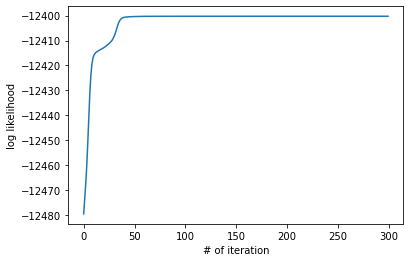

In [188]:
plt.plot(lls)
plt.xlabel("# of iteration")
plt.ylabel("log likelihood")

In [189]:
PP = np.array(positions_posterior_matrices)

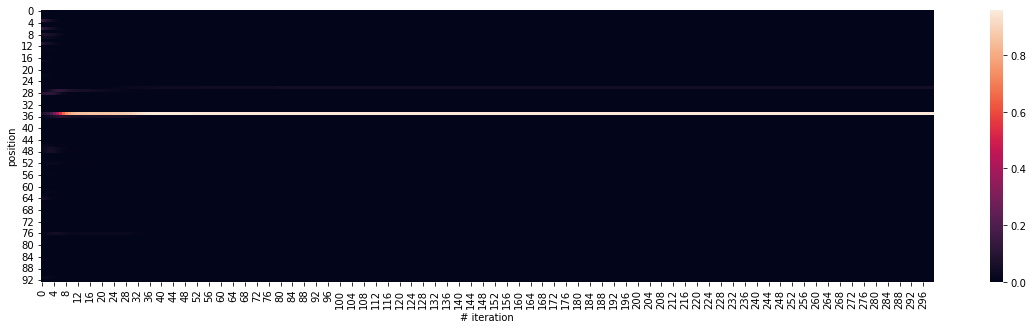

In [198]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(20, 5))

n_sequence_to_check = 44
sns.heatmap(PP[:,n_sequence_to_check,:].T, ax=ax);
ax.set_xlabel("# iteration");
ax.set_ylabel("position");

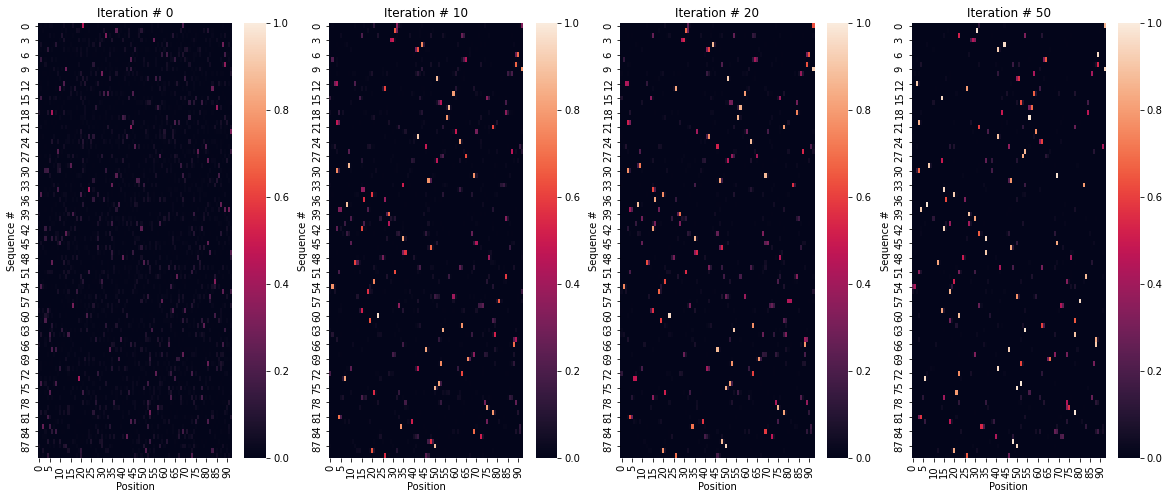

In [208]:
import seaborn as sns

fig, axs = plt.subplots(1, 4, figsize=(20, 8))

for ax, n_iter_to_see in zip(axs, [0, 10, 20, 50]):
    sns.heatmap(PP[n_iter_to_see,:,:], ax=ax, vmin=0, vmax=1);
    ax.set_title(f"Iteration # {n_iter_to_see}")
    ax.set_ylabel("Sequence #")
    ax.set_xlabel("Position")


## Function to draw simple logos

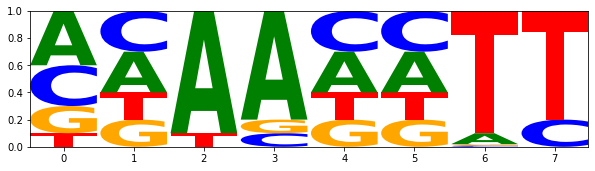

In [218]:
import logomaker
import pandas as pd
import warnings

def draw_motif(motif):
    # Make dataframe for logomake
    df = pd.DataFrame(motif, columns=["A", "C", "G", "T"])
    logo = logomaker.Logo(df)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore") 
        logo.fig.show()

draw_motif(motif)

## Draw motifs from Dirichlet, study convergence properties

In [219]:
def draw_motif_from_dirichlet(alpha, motif_length):
    rng = np.random.default_rng()
    return rng.dirichlet([alpha] * 4, motif_length)

### See how various alpha-s affect motif entropy

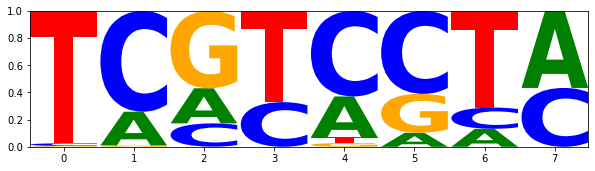

In [220]:
draw_motif(draw_motif_from_dirichlet(0.1, 8))

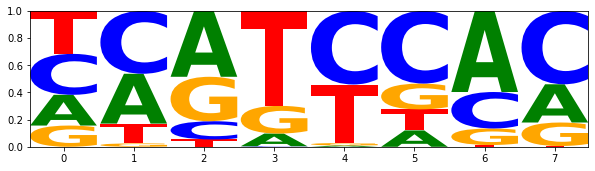

In [221]:
draw_motif(draw_motif_from_dirichlet(1, 8))

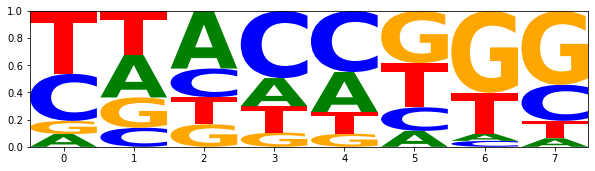

In [223]:
draw_motif(draw_motif_from_dirichlet(2, 8))

## Draw motif according to Dirichlet, estimate it with EM, then try some metrics

In [224]:
import scipy.stats


In [229]:
import scipy.stats

def motif_total_entropy(motif):
    return scipy.stats.entropy(motif, axis=1).sum()

def study_convergence(
    alpha,
    num_sequences,
    sequence_length,
    motif_length,
    n_iterations,
):
    # Draw motif
    true_motif = draw_motif_from_dirichlet(alpha, motif_length)
    
    # Draw sequences
    sequences, true_positions = generate_sequences_with_single_motif(num_sequences, sequence_length, true_motif)
    
    # Run EM 
    est_motif, lls, positions_posterior_matrices = \
        expectation_maximization(sequences, motif_length, n_iterations, print_every=10)
    
    # Draw true and estimated motifs
    draw_motif(true_motif)
    draw_motif(est_motif)
    
    # Print likelihoods
    print("Likelihod of true motif:", log_likelihood(sequences, true_motif))
    print("Likelihod of estimated motif:", log_likelihood(sequences, est_motif))
    
    # Print entropies
    print("Entropy of true motif:", motif_total_entropy(true_motif))
    print("Entropy of estimated motif:", motif_total_entropy(est_motif))


Iteration 0: LL = -12483.668291920303
Iteration 10: LL = -12465.954100303003
Iteration 20: LL = -12458.42519947524
Iteration 30: LL = -12457.861569433402
Iteration 40: LL = -12457.670146780185
Iteration 50: LL = -12457.529601320412
Iteration 60: LL = -12457.385356345827
Iteration 70: LL = -12457.207274238088
Iteration 80: LL = -12456.966268743123
Iteration 90: LL = -12456.683673679852
Likelihod of true motif: -12456.19630534084
Likelihod of estimated motif: -12456.446433344581
Entropy of true motif: 8.200869879941543
Entropy of estimated motif: 7.7714563550694535


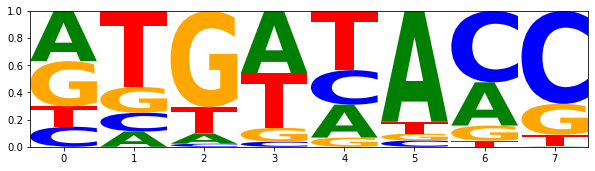

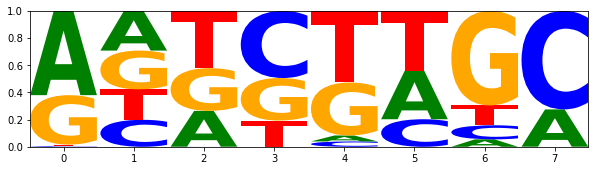

In [232]:
study_convergence(
    alpha = 1,
    num_sequences = 90,
    sequence_length = 100,
    motif_length = 8,
    n_iterations = 100,
)

Iteration 0: LL = -12477.805156041157
Iteration 10: LL = -12462.46564324053
Iteration 20: LL = -12457.952475854543
Iteration 30: LL = -12457.248642377344
Iteration 40: LL = -12456.901204678239
Iteration 50: LL = -12456.648458674346
Iteration 60: LL = -12456.391114890437
Iteration 70: LL = -12456.070105109531
Iteration 80: LL = -12455.756069538875
Iteration 90: LL = -12455.532079071532
Likelihod of true motif: -12475.760909049282
Likelihod of estimated motif: -12455.394245528398
Entropy of true motif: 9.758434468523769
Entropy of estimated motif: 7.651284772923757


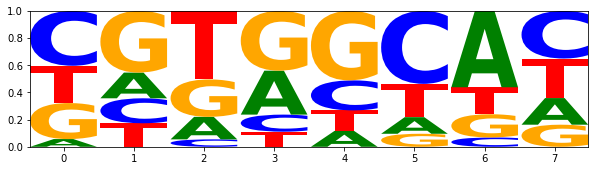

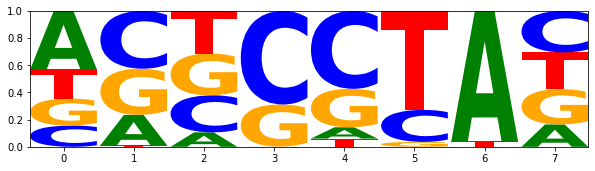

In [233]:
study_convergence(
    alpha = 2,
    num_sequences = 90,
    sequence_length = 100,
    motif_length = 8,
    n_iterations = 100,
)